## Single Head Initialization
In a Transformer, each token is passed through the model as a vector. The `hidden_size` defines how wide the token vector is when it reaches the Attention mechanism.

Our Attention layers will allow disabling bias terms for linear layers since recent papers and models, such as Cramming, Pythia, and PaLM, have shown that disabling the bias term results in little-to-no downstream performance drop while decreasing computational and memory requirements. However, to match the original Transformer implementation, we will set it on by default.

In this implementation, we will start merge Wa, WK 5, and WY into single linear layer, Wakv, and unbind the outputs into Q, K, and V. 

This is accomplished by increasing the output shape by a factor of three. This is mathematically equivalent to three individual linear layers, each with the same input and output shape.

In Multi-Head Attention, each individual head size is smaller than the input size?, so for Single Head we will arbitrarily set the head size to be four times smaller than the input dimension.

In [1]:
import numpy as np
import torch
from torch import nn

In [ ]:
# class SingleHeadAttention(nn.Module):
#     def __init__(self, hidden_size: int, bias: bool = True):
#         super().__init__()
#         # linear layer to project queries, keys, values
#         self.Wqkv = nn.Linear(hidden_size, (hidden_size//4)*3, bias=bias)        
#         # linear layer to project final output
#         self.Wo = nn.Linear(hidden_size//4, hidden_size, bias=bias)

With our linear projection layers created, we can now move to the forward method of the Attention layer.

## Single Head Forward

After some input shape housekeeping, the first computational step is to generate our keys, queries, and values. First, we pass the input x through the Wqkv linear layer. Then we reshape the Wqkv output to batch size, sequence length, one dimension for Q, K, & V, and the head size.

Finally, we split the single tensor into the query, key, and value tensors using unbind, where each are of shape B, S, C//4.

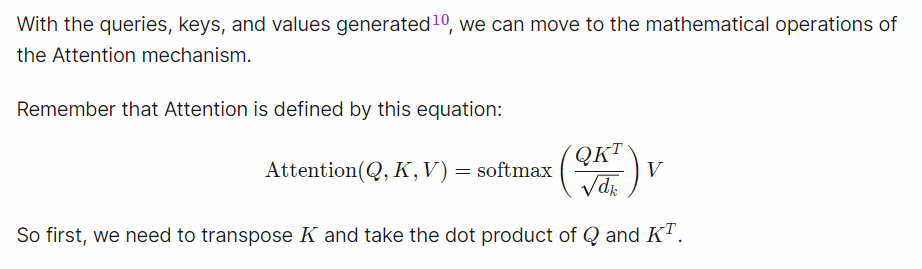

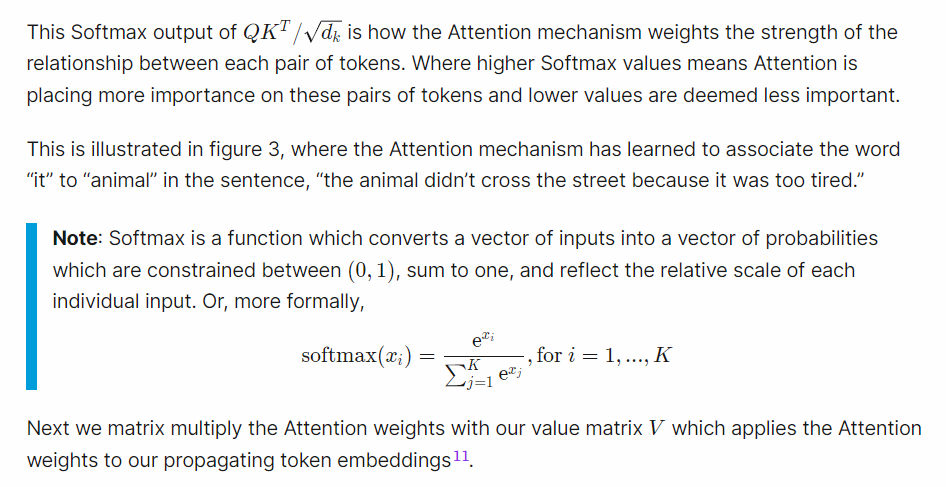

In [ ]:
class SingleHeadAttention(nn.Module):
    def __init__(self, hidden_size: int, bias: bool = True):
        super().__init__()
        # linear layer to project queries, keys, values
        self.Wqkv = nn.Linear(hidden_size, (hidden_size//4)*3, bias=bias)        
        # linear layer to project final output
        self.Wo = nn.Linear(hidden_size//4, hidden_size, bias=bias)

    def forward(self, x):
        # batch size (B), sequence length (S), input dimension (C)
        B, S, C = x.shape

        # split into queries, keys, & values of shape
        # batch size (B), sequence length (S), head size (HS)
        q, k, v = self.Wqkv(x).reshape(B, S, 3, C//4).unbind(dim=2)

        # calculate dot product of queries and keys of shape
        # (B, S, S) = (B, S, HS) @ (B, HS, S)
        attn = q @ k.transpose(-2, -1)

        # scale by square root of head dimension
        attn = attn / math.sqrt(k.size(-1))

        # apply softmax to get attention weights
        attn = attn.softmax(dim=-1)

        # dot product attention weights to values
        # (B, S, HS) = (B, S, S) @ (B, S, HS)
        x = attn @ v 

        return self.Wo(x)
